# Classification of Sorted Hands of Cards using the 'Abstracter' Model

In [1]:
#%%capture
#!git clone https://github.com/jdlafferty/relational.git
#!git checkout awni-debugging
#%cd relational

#!pip install pydealer
#!pip install wandb

In [2]:
import pydealer
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics

from hand2hand import Cards
import utils

In [3]:
%env WANDB_NOTEBOOK_NAME "abstracter_hand_classifier.ipynb"
%env

import wandb
wandb.login()

env: WANDB_NOTEBOOK_NAME="abstracter_hand_classifier.ipynb"


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "abstracter_hand_classifier.ipynb".
wandb: Currently logged in as: john-lafferty (wu-tsai-institute). Use `wandb login --relogin` to force relogin


True

In [4]:
# utility functions

card_image_shape = (178, 122, 3)
hand_size = 7
class_names = ['not sorted', 'sorted']

def create_callbacks(monitor='loss', log_gradients=False, save_model=True, log_weights=True,
                     train_ds=None, val_ds=None, ):
    callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
#         wandb.keras.WandbMetricsLogger(log_freq='epoch'),
#         wandb.keras,WandbModelCheckpoint(monitor='loss', mode='auto', save_freq='epoch')
        wandb.keras.WandbCallback(
            monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
            training_data=train_ds, validation_data=val_ds,
            labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam()

def get_preds(model, ds, print_classification_report=True):
    y_pred_proba = model.predict(ds.batch(128))
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.array([y for x,y in ds])
    if print_classification_report:
        print(sklearn.metrics.classification_report(y_true[:,1], y_pred))

    return y_true, y_pred_proba, y_pred

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})

def wrap_run(model, ds):
    y_true, y_pred_proba, y_pred = get_preds(model, ds, print_classification_report=True)
    log_to_wandb(y_true, y_pred_proba, y_pred)
    wandb.finish()

# Defining 'Abstracter' Model

In this section, we define the different components of the Abstracter model. (A few minor modifications are made to the implementation in `seq2seq_transformer.py`). In particular, we implement the following layers:

- `AddPositionalEmbedding`: Here, I define a layer which only adds a positional encoding, without embedding tokens. Rather than expecting a sequence of tokens as input, it expects a sequence of vectors, and simply adds a positional encoding to each vector elemntwise in the sequence. Just defining this to separate out the 'token embedding' and 'positional encoding' steps in the model since if the input sequence is (for e.g.) a sequence of images rather than a sequence of tokens, we would need to embed them differently, but still need to add a positional embedding.

- `Encoder`: Exactly the same implementation as `seq2seq_transformer.py`, except I'm removing the part of the layer that embeds the sequence and adds a positional embedding (just to separate out the computations a bit more to make things more modular).

- `EpisodicDecoder`: Just changed the implementation so that the input sequence vector parameters are explicitly a parameter of the model (so that we don't have to pass in a fixed one-hot vector sequence as input to achieve the desired effect, this is now built in). Also added option to turn off adding positional encoding.

In [5]:
import seq2seq_transformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Sequential
from seq2seq_transformer import (EncoderLayer, DecoderLayer, positional_encoding, EpisodicDecoderLayer,
                                 BaseAttention, GlobalSelfAttention, FeedForward)

In [6]:
# define non-token positional embedding layer (for vector input; just adds positional embedding)
# defining this to separate the 'adding positional embedding' from the 'token embedder' steps

class AddPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, name='add_positional_embedding'):
        super().__init__(name=name)

    def build(self, input_shape):
        _, self.seq_length, self.vec_dim = input_shape
        # compute fixed positional encoding to be added
        # TODO: why length=2048 and not seq_length?
        self.pos_encoding = positional_encoding(length=2048, depth=self.vec_dim)

    def call(self, x):
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.vec_dim, tf.float32))

        # add positional encoding
        x = x + self.pos_encoding[tf.newaxis, :self.seq_length, :] # NOTE: see build

        return x

In [7]:
# TODO: name something else? more specific name? e.g.: AbstracterEncoder/TransformerEncoder/...

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads,
               dff, dropout_rate=0.1, name='encoder'):

        super().__init__(name=name)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
    
        _, self.sequence_length, self.d_model = input_shape

        self.enc_layers = [
            EncoderLayer(d_model=self.d_model,
                         num_heads=self.num_heads,
                         dff=self.dff,
                         dropout_rate=self.dropout_rate)
            for _ in range(self.num_layers)
            ]

        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

    
    def call(self, x):
        # `x` is shape: (batch, seq_len, vec_dim)

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`

In [8]:
# Original Episodic Decoder with Q=E, K=E, V=D
class EpisodicDecoder(tf.keras.layers.Layer):
    """
    The 'Decoder' of the 'Abstracter' Model.
    
    Based on the Transformer's decoder, except with the modification that
    the queries and keys now both come from the encoder, and the values come
    from the decoder. The input at the decoder is now a learned parameter.
    """
    def __init__(self, num_layers, num_heads, dff, use_pos_embedding=True,
               dropout_rate=0.1, name='episodic_decoder'):
        super(EpisodicDecoder, self).__init__(name=name)
        
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.use_pos_embedding = use_pos_embedding
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        
        _, self.sequence_length, self.d_model = input_shape

        # define the input-independent symbolic input vector sequence at the decoder
        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.decoder_symbol_sequence = tf.Variable(
            normal_initializer(shape=(self.sequence_length, self.d_model)),
            trainable=True)

        # layer which adds positional embedding (to be used on symbol sequence)
        if self.use_pos_embedding:
            self.add_pos_embedding = AddPositionalEmbedding()
        
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
    
        self.dec_layers = [
            EpisodicDecoderLayer(d_model=self.d_model, num_heads=self.num_heads,
                         dff=self.dff, dropout_rate=self.dropout_rate)
            for _ in range(self.num_layers)]

        self.last_attn_scores = None

    def call(self, encoder_context):
        # symbol sequence is input independent, so use the same one for all computations in the given batch
        symbol_seq = tf.zeros_like(encoder_context) + self.decoder_symbol_sequence
    
        # add positional embedding
        if self.use_pos_embedding:
            symbol_seq = self.add_pos_embedding(symbol_seq)

        symbol_seq = self.dropout(symbol_seq)

        for i in range(self.num_layers):
            symbol_seq = self.dec_layers[i](symbol_seq, encoder_context)

#             self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return symbol_seq

## Build Card Image Encoder via Training on Card Classification Task

Here, we build an encoder for our relational model(s) by training on another task. In particular, we train a CNN model which classifies the card from its image. From this we will use the intermediate encoder inside this model as well as the full classifier as encoders for our input sequence in the relational model. 

In [9]:

# create card classification dataset
card_rank_dict = pydealer.DEFAULT_RANKS['values']
card_suit_dict = pydealer.DEFAULT_RANKS['suits']

def card_classification_generator():
    deck = Cards()
    pydeck = pydealer.Deck()

    for card in pydeck:
        x = deck.image_of_pycard(card) / 255
        y = deck.index_of_card(card)
        yield x,y

card_classification_ds = tf.data.Dataset.from_generator(
     card_classification_generator,
     output_signature=(
         tf.TensorSpec(shape=card_image_shape, dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.int32))
    )


In [10]:
img_input = layers.Input(shape=card_image_shape, name='card_image')

x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
x = layers.MaxPooling2D((4,4))(x)
x = layers.Conv2D(32, (5, 5), activation='relu')(x)
x = layers.MaxPooling2D((4,4))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='tanh')(x)

card_encoder = Model(inputs=img_input, outputs=x, name='card_encoder')
card_classification = layers.Dense(52, name='card_classification')(card_encoder(img_input))

cnn_card_clf = Model(inputs=img_input, outputs=card_classification, name='card_cnn')

cnn_card_clf.summary()

cnn_card_clf.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=['accuracy'])

Model: "card_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 card_image (InputLayer)     [(None, 178, 122, 3)]     0         
                                                                 
 card_encoder (Functional)   (None, 32)                83392     
                                                                 
 card_classification (Dense)  (None, 52)               1716      
                                                                 
Total params: 85,108
Trainable params: 85,108
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = cnn_card_clf.fit(card_classification_ds.batch(52), epochs=75, verbose=0)

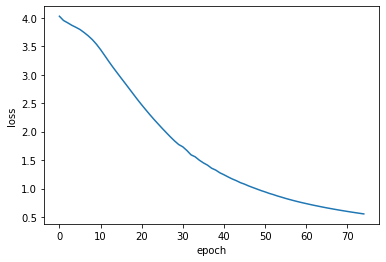

In [12]:
plt.plot(history.history['loss']);
plt.xlabel('epoch'); plt.ylabel('loss');

## Hand Classification Datasets: Tokenized Input and Image Input

In this section, we define the hand classification datasets. We define two datasets. In one, the input sequence is a sequence of tokens with a vocab size of 52. In the other, the input sequence is a sequence of images. The datasets are generated dynamically by defining a 'generator' and using the tensorflow data API. This means that when no seed is specified, the training dataset will be different at each epoch (since the generation process involves randomness). When a seed is specified, the data generated is repeatable.

In [13]:
# create 'toy' dataset where the cards in the input sequence are represented as an index in a vocab of length 52 

train_size = 10000

def create_tokenized_hand_clf_ds(seed=None, train_size=train_size):
    

    def tokenized_hand_clf_ds_generator():
        np.random.seed(seed) # optionally set seed for repeatability if desired

        deck = Cards()
        pydeck = pydealer.Deck()
        pydeck.shuffle()

        for i in np.arange(train_size):
            hand = pydeck.deal(hand_size)
            if len(hand) < hand_size:
                # ran out of cards, make a new deck
                pydeck = pydealer.Deck()
                pydeck.shuffle()
                hand = pydeck.deal(hand_size)
            if np.random.normal() < 0:
                deck.sort_pyhand(hand)

            x = deck.index_pyhand(hand)
            y = deck.is_sorted_pyhand(hand)
            yield x, y

    ds = tf.data.Dataset.from_generator(
         tokenized_hand_clf_ds_generator,
         output_signature=(
             tf.TensorSpec(shape=(hand_size, ), dtype=tf.int32),
             tf.TensorSpec(shape=(), dtype=tf.int32))
        )

    ds = ds.map(lambda x,y: (x, tf.one_hot(y,2)))
    
    return ds

In [14]:
# define dataset generator for sequence of card images

def create_img_hand_clf_ds(seed=None, train_size=train_size):
    
    
    def hand_classification_generator():
        np.random.seed(seed) # set seed for reproducibility of results

        deck = Cards()
        pydeck = pydealer.Deck()
        pydeck.shuffle()

        for i in np.arange(train_size):
            hand = pydeck.deal(hand_size)
            if len(hand) < hand_size:
                # ran out of cards, make a new deck
                pydeck = pydealer.Deck()
                pydeck.shuffle()
                hand = pydeck.deal(hand_size)
            if np.random.normal() < 0:
                deck.sort_pyhand(hand)

            x = np.array([deck.image_of_pycard(hand[j]) / 255 for j in range(hand_size)])
            y = deck.is_sorted_pyhand(hand)
            yield x,y

    ds = tf.data.Dataset.from_generator(
         hand_classification_generator,
         output_signature=(
             tf.TensorSpec(shape=(hand_size, *card_image_shape), dtype=tf.float32),
             tf.TensorSpec(shape=(), dtype=tf.int32))
        )
    
    ds = ds.map(lambda x,y: (x, tf.one_hot(y,2)))
    
    return ds

## RNN Model (Reference)

A simple GRU RNN model for reference. Tested with token input, and two variants of the card image encoder.

### Token Input

In [15]:
hand_input = layers.Input(shape=(hand_size, ))
x = layers.Embedding(52, 32, name='token_embedding')(hand_input)
x = layers.GRU(64, name='gru_rnn')(x)
x = layers.Dense(2, activation='softmax', name='output')(x)
rnn_clf = Model(hand_input, x, name='rnn_clf')
rnn_clf.summary()
rnn_clf.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                metrics=metrics)

Model: "rnn_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 token_embedding (Embedding)  (None, 7, 32)            1664      
                                                                 
 gru_rnn (GRU)               (None, 64)                18816     
                                                                 
 output (Dense)              (None, 2)                 130       
                                                                 
Total params: 20,610
Trainable params: 20,610
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_ds = create_tokenized_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RNN (Token Inputs)', save_code=True)

history = rnn_clf.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks(save_model=False))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Epoch 1/5
40/40 [==============================] - 4s 43ms/step - loss: 0.6193 - acc: 0.7909 - precision: 0.7615 - recall: 0.8416 - auc: 0.8687
Epoch 2/5
40/40 [==============================] - 2s 43ms/step - loss: 0.2143 - acc: 0.9206 - precision: 0.8800 - recall: 0.9728 - auc: 0.9791
Epoch 3/5
40/40 [==============================] - 2s 43ms/step - loss: 0.0942 - acc: 0.9706 - precision: 0.9556 - recall: 0.9870 - auc: 0.9935
Epoch 4/5
40/40 [==============================] - 2s 46ms/step - loss: 0.0687 - acc: 0.9796 - precision: 0.9680 - recall: 0.9915 - auc: 0.9958
Epoch 5/5
40/40 [==============================] - 2s 43ms/step - loss: 0.0520 - acc: 0.9833 - precision: 0.9742 - recall: 0.9925 - auc: 0.9978


In [17]:
test_ds = create_tokenized_hand_clf_ds(seed=42)
rnn_clf.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(rnn_clf, test_ds)

79/79 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98      4992
         1.0       0.95      1.00      0.98      5008

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



acc,▁▆███
auc,▁▇███
epoch,▁▃▅▆█
loss,█▃▂▁▁
precision,▁▅▇██
recall,▁▇███
GFLOPs,0.0
acc,0.9833
auc,0.99784
best_epoch,4
best_loss,0.05198


### Full Card Classifier as Encoder

In [18]:
hand_input = layers.Input(shape=(hand_size, *card_image_shape))
x = layers.TimeDistributed(cnn_card_clf, name='card_clf_encoder', trainable=False)(hand_input)
x = layers.GRU(64, name='gru_rnn')(x)
x = layers.Dense(2, activation='softmax', name='output')(x)
rnn_clf = Model(hand_input, x, name='rnn_clf')
rnn_clf.summary()
rnn_clf.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                metrics=metrics)

Model: "rnn_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 178, 122, 3)]  0         
                                                                 
 card_clf_encoder (TimeDistr  (None, 7, 52)            85108     
 ibuted)                                                         
                                                                 
 gru_rnn (GRU)               (None, 64)                22656     
                                                                 
 output (Dense)              (None, 2)                 130       
                                                                 
Total params: 107,894
Trainable params: 22,786
Non-trainable params: 85,108
_________________________________________________________________


In [19]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RNN (Image Inputs, Clf Encoder)', save_code=True)

history = rnn_clf.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks(save_model=False))

Epoch 1/5
40/40 [==============================] - 132s 3s/step - loss: 0.4959 - acc: 0.8731 - precision: 0.8498 - recall: 0.9091 - auc: 0.9534
Epoch 2/5
40/40 [==============================] - 135s 3s/step - loss: 0.2727 - acc: 0.9008 - precision: 0.8756 - recall: 0.9304 - auc: 0.9647
Epoch 3/5
40/40 [==============================] - 133s 3s/step - loss: 0.1043 - acc: 0.9673 - precision: 0.9538 - recall: 0.9822 - auc: 0.9942
Epoch 4/5
40/40 [==============================] - 136s 3s/step - loss: 0.0464 - acc: 0.9875 - precision: 0.9782 - recall: 0.9967 - auc: 0.9988
Epoch 5/5
40/40 [==============================] - 137s 3s/step - loss: 0.0302 - acc: 0.9911 - precision: 0.9849 - recall: 0.9974 - auc: 0.9994


In [20]:
test_ds = create_img_hand_clf_ds(seed=42)
rnn_clf.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(rnn_clf, test_ds)

79/79 [==============================] - 135s 2s/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      4992
         1.0       0.99      1.00      0.99      5008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



acc,▁▃▇██
auc,▁▃▇██
epoch,▁▃▅▆█
loss,█▅▂▁▁
precision,▁▂▆██
recall,▁▃▇██
GFLOPs,0.5248
acc,0.9911
auc,0.9994
best_epoch,4
best_loss,0.0302


### Classifier's Intermediate Encoder as Card Encoder

In [21]:
hand_input = layers.Input(shape=(hand_size, *card_image_shape))
x = layers.TimeDistributed(card_encoder, name='card_encoder', trainable=False)(hand_input)
x = layers.GRU(64, name='gru_rnn')(x)
x = layers.Dense(2, activation='softmax', name='output')(x)
rnn_clf = Model(hand_input, x, name='rnn_clf')
rnn_clf.summary()
rnn_clf.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                metrics=metrics)

Model: "rnn_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7, 178, 122, 3)]  0         
                                                                 
 card_encoder (TimeDistribut  (None, 7, 32)            83392     
 ed)                                                             
                                                                 
 gru_rnn (GRU)               (None, 64)                18816     
                                                                 
 output (Dense)              (None, 2)                 130       
                                                                 
Total params: 102,338
Trainable params: 18,946
Non-trainable params: 83,392
_________________________________________________________________


In [22]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RNN (Image Inputs, Intermediate Encoder)', save_code=True)

history = rnn_clf.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks(save_model=False))

Epoch 1/5
40/40 [==============================] - 136s 3s/step - loss: 0.5110 - acc: 0.8802 - precision: 0.8499 - recall: 0.9244 - auc: 0.9612
Epoch 2/5
40/40 [==============================] - 137s 3s/step - loss: 0.2800 - acc: 0.8982 - precision: 0.8682 - recall: 0.9319 - auc: 0.9615
Epoch 3/5
40/40 [==============================] - 156s 4s/step - loss: 0.1070 - acc: 0.9655 - precision: 0.9485 - recall: 0.9859 - auc: 0.9927
Epoch 4/5
40/40 [==============================] - 148s 4s/step - loss: 0.0536 - acc: 0.9835 - precision: 0.9744 - recall: 0.9930 - auc: 0.9979
Epoch 5/5
40/40 [==============================] - 154s 4s/step - loss: 0.0395 - acc: 0.9890 - precision: 0.9812 - recall: 0.9972 - auc: 0.9989


In [ ]:
test_ds = create_img_hand_clf_ds(seed=42)
rnn_clf.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(rnn_clf, test_ds)

## 'Abstracter' Model
This is the transformer-inspired relational model with an `EpisodicDecoder` (Q=E, K=E, V=D).

### Token Inputs

In [25]:
inputs = layers.Input(shape=(7,), name='token_input')
token_embedder = layers.Embedding(52, 32, name='vector_embedding')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=32, dropout_rate=0.1, name='abstracter_encoder')
symbolic = EpisodicDecoder(num_layers=3, num_heads=2, dff=32, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = token_embedder(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=metrics)

Model: "abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None, 7)]               0         
                                                                 
 vector_embedding (Embedding  (None, 7, 32)            1664      
 )                                                               
                                                                 
 add_pos_embedding (AddPosit  (None, 7, 32)            0         
 ionalEmbedding)                                                 
                                                                 
 abstracter_encoder (Encoder  (None, 7, 32)            31968     
 )                                                               
                                                                 
 abstracter_decoder (Episodi  (None, 7, 32)            57632     
 cDecoder)                                              

In [27]:
!pip install pydot
!pip install graphviz
tf.keras.utils.plot_model(abstracter_model)

/Users/lafferty/opt/anaconda3/lib/python3.8/site-packages/secretstorage/__init__.py:11: UserWarning: jeepney.integrate.blocking is deprecated: please use jeepney.io.blocking instead.
  from jeepney.integrate.blocking import DBusConnection, Proxy, \
/Users/lafferty/opt/anaconda3/lib/python3.8/site-packages/secretstorage/__init__.py:11: UserWarning: jeepney.integrate.blocking is deprecated: please use jeepney.io.blocking instead.
  from jeepney.integrate.blocking import DBusConnection, Proxy, \
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 900.2 kB/s eta 0:00:00 0:00:01
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
train_ds = create_tokenized_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Abstracter (Token Inputs)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

acc,▁▂▆██
auc,▁▁▇██
epoch,▁▃▅▆█
loss,█▅▂▁▁
precision,▁▂▆██
recall,▁▂▇██
GFLOPs,0.52479
acc,0.989
auc,0.99891
best_epoch,4
best_loss,0.03954


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
     39/Unknown - 16s 88ms/step - loss: 0.7033 - acc: 0.7518 - precision: 0.7532 - recall: 0.7514 - auc: 0.8752

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best)... Done. 0.0s


40/40 [==============================] - 31s 459ms/step - loss: 0.7032 - acc: 0.7517 - precision: 0.7532 - recall: 0.7512 - auc: 0.8751
Epoch 2/5
39/40 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.8611 - precision: 0.8414 - recall: 0.8916 - auc: 0.9329

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best)... Done. 0.0s


40/40 [==============================] - 19s 482ms/step - loss: 0.3364 - acc: 0.8612 - precision: 0.8416 - recall: 0.8918 - auc: 0.9329
Epoch 3/5
39/40 [============================>.] - ETA: 0s - loss: 0.0761 - acc: 0.9734 - precision: 0.9655 - recall: 0.9823 - auc: 0.9956

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best)... Done. 0.0s


40/40 [==============================] - 18s 462ms/step - loss: 0.0764 - acc: 0.9733 - precision: 0.9654 - recall: 0.9824 - auc: 0.9956
Epoch 4/5
39/40 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9878 - precision: 0.9833 - recall: 0.9921 - auc: 0.9980

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best)... Done. 0.0s


40/40 [==============================] - 19s 492ms/step - loss: 0.0392 - acc: 0.9878 - precision: 0.9833 - recall: 0.9921 - auc: 0.9980
Epoch 5/5
39/40 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9897 - precision: 0.9851 - recall: 0.9944 - auc: 0.9986

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_171755-20ftsm0m/files/model-best)... Done. 0.0s


40/40 [==============================] - 19s 476ms/step - loss: 0.0339 - acc: 0.9897 - precision: 0.9851 - recall: 0.9944 - auc: 0.9986


In [29]:
test_ds = create_tokenized_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

79/79 [==============================] - 3s 29ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      4991
         1.0       0.99      1.00      1.00      5009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



acc,▁▄███
auc,▁▄███
epoch,▁▃▅▆█
loss,█▄▁▁▁
precision,▁▄▇██
recall,▁▅███
GFLOPs,0.0001
acc,0.9897
auc,0.9986
best_epoch,4
best_loss,0.03389


### Full Classifier as Card Encoder

In [31]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=32, dropout_rate=0.1, name='abstracter_encoder')
symbolic = EpisodicDecoder(num_layers=3, num_heads=2, dff=32, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(cnn_card_clf, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=metrics)

Model: "abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 card_image_sequence (InputL  [(None, 7, 178, 122, 3)]  0        
 ayer)                                                           
                                                                 
 encode_cards (TimeDistribut  (None, 7, 52)            85108     
 ed)                                                             
                                                                 
 add_pos_embedding (AddPosit  (None, 7, 52)            0         
 ionalEmbedding)                                                 
                                                                 
 abstracter_encoder (Encoder  (None, 7, 52)            76848     
 )                                                               
                                                                 
 abstracter_decoder (Episodi  (None, 7, 52)            1

In [32]:
tf.keras.utils.plot_model(abstracter_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Abstracter (Image Input, Full Clf Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

Epoch 1/5
     40/Unknown - 153s 3s/step - loss: 0.5600 - acc: 0.8426 - precision: 0.8233 - recall: 0.8756 - auc: 0.9412

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best)... Done. 0.0s


40/40 [==============================] - 168s 4s/step - loss: 0.5600 - acc: 0.8426 - precision: 0.8233 - recall: 0.8756 - auc: 0.9412
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.2086 - acc: 0.9203 - precision: 0.9031 - recall: 0.9404 - auc: 0.9707

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best)... Done. 0.0s


40/40 [==============================] - 153s 4s/step - loss: 0.2086 - acc: 0.9203 - precision: 0.9031 - recall: 0.9404 - auc: 0.9707
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.1073 - acc: 0.9625 - precision: 0.9505 - recall: 0.9772 - auc: 0.9912

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best)... Done. 0.0s


40/40 [==============================] - 156s 4s/step - loss: 0.1073 - acc: 0.9625 - precision: 0.9505 - recall: 0.9772 - auc: 0.9912
Epoch 4/5
40/40 [==============================] - ETA: 0s - loss: 0.0807 - acc: 0.9742 - precision: 0.9652 - recall: 0.9841 - auc: 0.9936

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best)... Done. 0.0s


40/40 [==============================] - 158s 4s/step - loss: 0.0807 - acc: 0.9742 - precision: 0.9652 - recall: 0.9841 - auc: 0.9936
Epoch 5/5
40/40 [==============================] - ETA: 0s - loss: 0.0666 - acc: 0.9777 - precision: 0.9722 - recall: 0.9836 - auc: 0.9957

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_172200-19uimqbt/files/model-best)... Done. 0.0s


40/40 [==============================] - 155s 4s/step - loss: 0.0666 - acc: 0.9777 - precision: 0.9722 - recall: 0.9836 - auc: 0.9957


In [34]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

79/79 [==============================] - 136s 2s/step
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      4992
         1.0       0.97      1.00      0.99      5008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



acc,▁▅▇██
auc,▁▅▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
precision,▁▅▇██
recall,▁▅███
GFLOPs,0.52495
acc,0.9777
auc,0.9957
best_epoch,4
best_loss,0.06664


### Classifier's Intermediate Encoder as Card Encoder

In [35]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=32, dropout_rate=0.1, name='abstracter_encoder')
symbolic = EpisodicDecoder(num_layers=3, num_heads=2, dff=32, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(card_encoder, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=metrics)

Model: "abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 card_image_sequence (InputL  [(None, 7, 178, 122, 3)]  0        
 ayer)                                                           
                                                                 
 encode_cards (TimeDistribut  (None, 7, 32)            83392     
 ed)                                                             
                                                                 
 add_pos_embedding (AddPosit  (None, 7, 32)            0         
 ionalEmbedding)                                                 
                                                                 
 abstracter_encoder (Encoder  (None, 7, 32)            31968     
 )                                                               
                                                                 
 abstracter_decoder (Episodi  (None, 7, 32)            5

In [ ]:
tf.keras.utils.plot_model(abstracter_model)

In [36]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Abstracter (Image Input, Intermediate Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

Epoch 1/5
     40/Unknown - 147s 3s/step - loss: 0.6600 - acc: 0.7882 - precision: 0.7844 - recall: 0.7944 - auc: 0.9012

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best)... Done. 0.0s


40/40 [==============================] - 162s 4s/step - loss: 0.6600 - acc: 0.7882 - precision: 0.7844 - recall: 0.7944 - auc: 0.9012
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.3799 - acc: 0.8376 - precision: 0.8371 - recall: 0.8384 - auc: 0.9107

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best)... Done. 0.0s


40/40 [==============================] - 150s 4s/step - loss: 0.3799 - acc: 0.8376 - precision: 0.8371 - recall: 0.8384 - auc: 0.9107
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.2165 - acc: 0.9166 - precision: 0.9004 - recall: 0.9349 - auc: 0.9695

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best)... Done. 0.0s


40/40 [==============================] - 152s 4s/step - loss: 0.2165 - acc: 0.9166 - precision: 0.9004 - recall: 0.9349 - auc: 0.9695
Epoch 4/5
40/40 [==============================] - ETA: 0s - loss: 0.1649 - acc: 0.9393 - precision: 0.9230 - recall: 0.9583 - auc: 0.9800

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best)... Done. 0.0s


40/40 [==============================] - 151s 4s/step - loss: 0.1649 - acc: 0.9393 - precision: 0.9230 - recall: 0.9583 - auc: 0.9800
Epoch 5/5
40/40 [==============================] - ETA: 0s - loss: 0.1117 - acc: 0.9613 - precision: 0.9517 - recall: 0.9711 - auc: 0.9903

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_174241-3sw16jj8/files/model-best)... Done. 0.0s


40/40 [==============================] - 151s 4s/step - loss: 0.1117 - acc: 0.9613 - precision: 0.9517 - recall: 0.9711 - auc: 0.9903


In [37]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

79/79 [==============================] - 136s 2s/step
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      4991
         1.0       0.95      1.00      0.97      5009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



acc,▁▃▆▇█
auc,▁▂▆▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
precision,▁▃▆▇█
recall,▁▃▇▇█
GFLOPs,0.52488
acc,0.9613
auc,0.99033
best_epoch,4
best_loss,0.11169


## "Symbolic Abstracter": Variant of Model with Symbol-Encoding Cross-Attention

- `SymbolicDecoder`: This is the variant where Q=D, K=E, V=D. The learned sequence of input vectors at the decoder can be thought of as abstract symbols, and their relations with the entities at the encoder (via cross-attention) can be thought of as bindings between the symbols and attributes of the input.

In [38]:
class SymbolicDecoder(tf.keras.layers.Layer):
    """Symbolic Decoder (Q=D, K=E, V=D)"""
    def __init__(self, num_layers, num_heads, dff, use_pos_embedding=True,
               dropout_rate=0.1, name='symbolic_decoder'):
        super(SymbolicDecoder, self).__init__(name=name)

        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.use_pos_embedding = use_pos_embedding
        self.dropout_rate = dropout_rate

    def build(self, input_shape):

        _, self.sequence_length, self.d_model = input_shape

        # define the input-independent symbolic input vector sequence at the decoder
        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.decoder_symbol_sequence = tf.Variable(
            normal_initializer(shape=(self.sequence_length, self.d_model)),
            trainable=True)

        # layer which adds positional embedding (to be used on symbol sequence)
        if self.use_pos_embedding:
            self.add_pos_embedding = AddPositionalEmbedding()

        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

        self.dec_layers = [
            SymbolicDecoderLayer(d_model=self.d_model, num_heads=self.num_heads,
                         dff=self.dff, dropout_rate=self.dropout_rate)
            for _ in range(self.num_layers)]

        self.last_attn_scores = None

    def call(self, encoder_context):
        # symbol sequence is input independent, so use the same one for all computations in the given batch
        symbol_seq = tf.zeros_like(encoder_context) + self.decoder_symbol_sequence

        # add positional embedding
        if self.use_pos_embedding:
            symbol_seq = self.add_pos_embedding(symbol_seq)


        symbol_seq = self.dropout(symbol_seq)


        for i in range(self.num_layers):
            symbol_seq = self.dec_layers[i](symbol_seq, encoder_context)

#             self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return symbol_seq

class SymbolicDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, name=None):
        super(SymbolicDecoderLayer, self).__init__(name=name)

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.symbolic_attention = SymbolicAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.self_attention(x=x)
        x = self.symbolic_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.symbolic_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

        return x

class SymbolicAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=x ,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])

        x = self.layernorm(x)

        return x

### Token Inputs

In [39]:
inputs = layers.Input(shape=(7,), name='token_input')
token_embedder = layers.Embedding(52, 32, name='vector_embedding')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=32, dropout_rate=0.1, name='abstracter_encoder')
symbolic_decoder = SymbolicDecoder(num_layers=3, num_heads=2, dff=32, use_pos_embedding=True,
                                   dropout_rate=0.1, name='symbolic_decoder')


x = token_embedder(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic_decoder(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=metrics)

Model: "abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None, 7)]               0         
                                                                 
 vector_embedding (Embedding  (None, 7, 32)            1664      
 )                                                               
                                                                 
 add_pos_embedding (AddPosit  (None, 7, 32)            0         
 ionalEmbedding)                                                 
                                                                 
 abstracter_encoder (Encoder  (None, 7, 32)            31968     
 )                                                               
                                                                 
 symbolic_decoder (SymbolicD  (None, 7, 32)            57632     
 ecoder)                                                

In [ ]:
tf.keras.utils.plot_model(abstracter_model)

In [40]:
train_ds = create_tokenized_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Symbolic Abstracter (Token Inputs)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

Epoch 1/5
     39/Unknown - 16s 92ms/step - loss: 0.6896 - acc: 0.7566 - precision: 0.7439 - recall: 0.7869 - auc: 0.8748

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best)... Done. 0.0s


40/40 [==============================] - 31s 472ms/step - loss: 0.6893 - acc: 0.7566 - precision: 0.7439 - recall: 0.7870 - auc: 0.8748
Epoch 2/5
39/40 [============================>.] - ETA: 0s - loss: 0.1853 - acc: 0.9346 - precision: 0.9282 - recall: 0.9414 - auc: 0.9787

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best)... Done. 0.0s


40/40 [==============================] - 19s 482ms/step - loss: 0.1850 - acc: 0.9347 - precision: 0.9283 - recall: 0.9415 - auc: 0.9787
Epoch 3/5
39/40 [============================>.] - ETA: 0s - loss: 0.0580 - acc: 0.9828 - precision: 0.9774 - recall: 0.9887 - auc: 0.9963

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best)... Done. 0.0s


40/40 [==============================] - 20s 503ms/step - loss: 0.0579 - acc: 0.9828 - precision: 0.9775 - recall: 0.9887 - auc: 0.9963
Epoch 4/5
39/40 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9871 - precision: 0.9819 - recall: 0.9923 - auc: 0.9970

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best)... Done. 0.0s


40/40 [==============================] - 19s 472ms/step - loss: 0.0443 - acc: 0.9871 - precision: 0.9819 - recall: 0.9924 - auc: 0.9970
Epoch 5/5
39/40 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9923 - precision: 0.9891 - recall: 0.9956 - auc: 0.9988

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_182732-373ckmny/files/model-best)... Done. 0.0s


40/40 [==============================] - 20s 497ms/step - loss: 0.0286 - acc: 0.9923 - precision: 0.9891 - recall: 0.9956 - auc: 0.9988


In [41]:
test_ds = create_tokenized_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

79/79 [==============================] - 4s 30ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      4991
         1.0       0.99      1.00      0.99      5009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



acc,▁▆███
auc,▁▇███
epoch,▁▃▅▆█
loss,█▃▁▁▁
precision,▁▆███
recall,▁▆███
GFLOPs,0.0001
acc,0.9923
auc,0.99879
best_epoch,4
best_loss,0.02864


### Full Classifier as Card Encoder

In [42]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=32, dropout_rate=0.1, name='abstracter_encoder')
symbolic = SymbolicDecoder(num_layers=3, num_heads=2, dff=32, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(cnn_card_clf, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=metrics)

Model: "abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 card_image_sequence (InputL  [(None, 7, 178, 122, 3)]  0        
 ayer)                                                           
                                                                 
 encode_cards (TimeDistribut  (None, 7, 52)            85108     
 ed)                                                             
                                                                 
 add_pos_embedding (AddPosit  (None, 7, 52)            0         
 ionalEmbedding)                                                 
                                                                 
 abstracter_encoder (Encoder  (None, 7, 52)            76848     
 )                                                               
                                                                 
 abstracter_decoder (Symboli  (None, 7, 52)            1

In [ ]:
tf.keras.utils.plot_model(abstracter_model)

In [43]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Symbolic Abstracte (Image Input, Full Clf Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

Epoch 1/5
     40/Unknown - 163s 4s/step - loss: 0.5818 - acc: 0.8296 - precision: 0.8153 - recall: 0.8543 - auc: 0.9332

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best)... Done. 0.0s


40/40 [==============================] - 180s 4s/step - loss: 0.5818 - acc: 0.8296 - precision: 0.8153 - recall: 0.8543 - auc: 0.9332
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.1789 - acc: 0.9357 - precision: 0.9236 - recall: 0.9481 - auc: 0.9781

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best)... Done. 0.0s


40/40 [==============================] - 164s 4s/step - loss: 0.1789 - acc: 0.9357 - precision: 0.9236 - recall: 0.9481 - auc: 0.9781
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.1036 - acc: 0.9643 - precision: 0.9545 - recall: 0.9761 - auc: 0.9915

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best)... Done. 0.0s


40/40 [==============================] - 166s 4s/step - loss: 0.1036 - acc: 0.9643 - precision: 0.9545 - recall: 0.9761 - auc: 0.9915
Epoch 4/5
40/40 [==============================] - ETA: 0s - loss: 0.0820 - acc: 0.9726 - precision: 0.9648 - recall: 0.9810 - auc: 0.9942

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best)... Done. 0.0s


40/40 [==============================] - 161s 4s/step - loss: 0.0820 - acc: 0.9726 - precision: 0.9648 - recall: 0.9810 - auc: 0.9942
Epoch 5/5
40/40 [==============================] - ETA: 0s - loss: 0.0624 - acc: 0.9804 - precision: 0.9731 - recall: 0.9882 - auc: 0.9959

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_183132-34m0zy1x/files/model-best)... Done. 0.0s


40/40 [==============================] - 165s 4s/step - loss: 0.0624 - acc: 0.9804 - precision: 0.9731 - recall: 0.9882 - auc: 0.9959


In [44]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

79/79 [==============================] - 143s 2s/step
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      4991
         1.0       0.97      1.00      0.98      5009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



acc,▁▆▇██
auc,▁▆███
epoch,▁▃▅▆█
loss,█▃▂▁▁
precision,▁▆▇██
recall,▁▆▇██
GFLOPs,0.52495
acc,0.9804
auc,0.99593
best_epoch,4
best_loss,0.06243


### Classifier's Intermediate Encoder as Card Encoder

In [46]:
inputs = layers.Input(shape=(hand_size,*card_image_shape), name='card_image_sequence')
pos_embedding_adder = AddPositionalEmbedding(name='add_pos_embedding')
abstracter_encoder = Encoder(num_layers=3, num_heads=2, dff=32, dropout_rate=0.1, name='abstracter_encoder')
symbolic_decoder = SymbolicDecoder(num_layers=3, num_heads=2, dff=32, use_pos_embedding=True,
                                   dropout_rate=0.1, name='abstracter_decoder')


x = layers.TimeDistributed(card_encoder, name='encode_cards', trainable=False)(inputs)
x = pos_embedding_adder(x)

x = abstracter_encoder(x)

x = symbolic_decoder(x)

x = layers.GlobalAveragePooling1D(name='sequence_avg_pool')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

abstracter_model = tf.keras.Model(inputs, outputs, name='abstracter')
abstracter_model.summary()

abstracter_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=metrics)

Model: "abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 card_image_sequence (InputL  [(None, 7, 178, 122, 3)]  0        
 ayer)                                                           
                                                                 
 encode_cards (TimeDistribut  (None, 7, 32)            83392     
 ed)                                                             
                                                                 
 add_pos_embedding (AddPosit  (None, 7, 32)            0         
 ionalEmbedding)                                                 
                                                                 
 abstracter_encoder (Encoder  (None, 7, 32)            31968     
 )                                                               
                                                                 
 abstracter_decoder (Symboli  (None, 7, 32)            5

In [ ]:
tf.keras.utils.plot_model(abstracter_model)

In [47]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='Symbolic Abstracter (Image Input, Intermediate Encoder)', save_code=True)

history = abstracter_model.fit(train_ds.batch(256), epochs=5, callbacks=create_callbacks())

Epoch 1/5
     40/Unknown - 156s 4s/step - loss: 0.6781 - acc: 0.7695 - precision: 0.7772 - recall: 0.7512 - auc: 0.8889

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best)... Done. 0.0s


40/40 [==============================] - 171s 4s/step - loss: 0.6781 - acc: 0.7695 - precision: 0.7772 - recall: 0.7512 - auc: 0.8889
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.2930 - acc: 0.8858 - precision: 0.8730 - recall: 0.8982 - auc: 0.9458

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best)... Done. 0.0s


40/40 [==============================] - 160s 4s/step - loss: 0.2930 - acc: 0.8858 - precision: 0.8730 - recall: 0.8982 - auc: 0.9458
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.1584 - acc: 0.9413 - precision: 0.9264 - recall: 0.9591 - auc: 0.9828

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best)... Done. 0.0s


40/40 [==============================] - 159s 4s/step - loss: 0.1584 - acc: 0.9413 - precision: 0.9264 - recall: 0.9591 - auc: 0.9828
Epoch 4/5
40/40 [==============================] - ETA: 0s - loss: 0.1035 - acc: 0.9648 - precision: 0.9540 - recall: 0.9766 - auc: 0.9908

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best)... Done. 0.0s


40/40 [==============================] - 160s 4s/step - loss: 0.1035 - acc: 0.9648 - precision: 0.9540 - recall: 0.9766 - auc: 0.9908
Epoch 5/5
40/40 [==============================] - ETA: 0s - loss: 0.0810 - acc: 0.9738 - precision: 0.9651 - recall: 0.9838 - auc: 0.9941

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best/assets
wandb: Adding directory to artifact (/Users/lafferty/Downloads/relational/wandb/run-20230110_185145-qd838l3f/files/model-best)... Done. 0.0s


40/40 [==============================] - 158s 4s/step - loss: 0.0810 - acc: 0.9738 - precision: 0.9651 - recall: 0.9838 - auc: 0.9941


In [48]:
test_ds = create_img_hand_clf_ds(seed=42)
abstracter_model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(abstracter_model, test_ds)

79/79 [==============================] - 141s 2s/step
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      4991
         1.0       0.97      1.00      0.98      5009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



acc,▁▅▇██
auc,▁▅▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
precision,▁▅▇██
recall,▁▅▇██
GFLOPs,0.52488
acc,0.9738
auc,0.99407
best_epoch,4
best_loss,0.08104
